In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import copy
import numpy as np
import os

In [2]:
rutaArchivoDatos = (r"./recursos/1000gruposCluster.csv")
#el modelo y todos los archivos de salida se guardaran en el directorio ./modelos/
nombreModeloSalida = "forestRegressor.joblib"

In [3]:
data = pd.read_csv(rutaArchivoDatos)

data_filtered = data.drop(['NumParadas', 'PorcentajePunto', 'Retraso', 'Cluster'], axis=1)
print(data_filtered.head())

label_encoder_array = []
for col in data_filtered.columns:
    if data_filtered[col].dtype == 'object':
        label_encoder = LabelEncoder()
        data_filtered[col] = label_encoder.fit_transform(data[col])
        new_label_encoder = copy.deepcopy(label_encoder)
        label_encoder_array.append(new_label_encoder)

print(data_filtered.head())

  IDConductor CodigoInternoPuntoCarga  LatitudPuntoCarga  LongitudPuntoCarga  \
0   Y4446672G                      03            41.1996              1.2194   
1   Y4446672G                      03            41.1996              1.2194   
2   46401708J                      03            41.1996              1.2194   
3   46401708J                      03            41.1996              1.2194   
4   52069433D                      03            41.1996              1.2194   

  CodigoInternoPuntoDescarga  LatitudPuntoDescarga  LongitudPuntoDescarga  \
0                    C115205               41.1535                 1.2126   
1                    C115205               41.1535                 1.2126   
2                    C115205               41.1535                 1.2126   
3                    C115205               41.1535                 1.2126   
4                    C115205               41.1535                 1.2126   

   KmVacio  Puntuacion  
0      218        33.7  
1     

In [4]:
X = data_filtered.drop('Puntuacion', axis=1)  # Ajusta 'target_column' al nombre de tu columna de destino
y = data_filtered['Puntuacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
max_depth = 23
random_state = 11
print(f"Parametros defecto: max_depth={max_depth}, random_state={random_state}")
respuesta = input("Desea comprobar parametros mas optimos (~8 min)? (s/n)")

if respuesta.lower() == "s":
    scores = []
    for max_depth in range(1, 40):
        print(f"Probando bosque con depth={max_depth}")
        clf = RandomForestRegressor(max_depth=max_depth, verbose=0, n_jobs=4, criterion='squared_error')
        clf.fit(X_train, y_train)
        print(f"Score: {clf.score(X_test, y_test)}")
        scores.append(clf.score(X_test, y_test))
    plt.plot(range(1, 40), scores)
    plt.xlabel('Max Depth')
    plt.ylabel('Score')
    plt.show()
    max_depth = scores.index(max(scores)) + 1
    r2_scores = []
    for random_state in range(1,40):
        print(f"Probando bosque con random_state={random_state}")
        model = RandomForestRegressor(verbose=0, n_jobs=4, max_depth=max_depth, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))
    plt.plot(range(1, 40), r2_scores)
    plt.xlabel('Random state')
    plt.ylabel('Score')
    plt.show()
    print("Mejor random state: ", r2_scores.index(max(r2_scores)))
    random_state = r2_scores.index(max(r2_scores)) + 1

Parametros defecto: max_depth=23, random_state=11


In [6]:
model = RandomForestRegressor(  n_estimators=190,
                                verbose=0, 
                                n_jobs=4, 
                                max_depth=max_depth, 
                                random_state=random_state, 
                                # min_samples_split=49
                            )
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=23, n_estimators=190, n_jobs=4, random_state=11)

                      Feature  Importance
7                     KmVacio    0.673973
0                 IDConductor    0.087261
4  CodigoInternoPuntoDescarga    0.071532
2           LatitudPuntoCarga    0.056782
5        LatitudPuntoDescarga    0.033693
1     CodigoInternoPuntoCarga    0.032157
6       LongitudPuntoDescarga    0.026880
3          LongitudPuntoCarga    0.017723


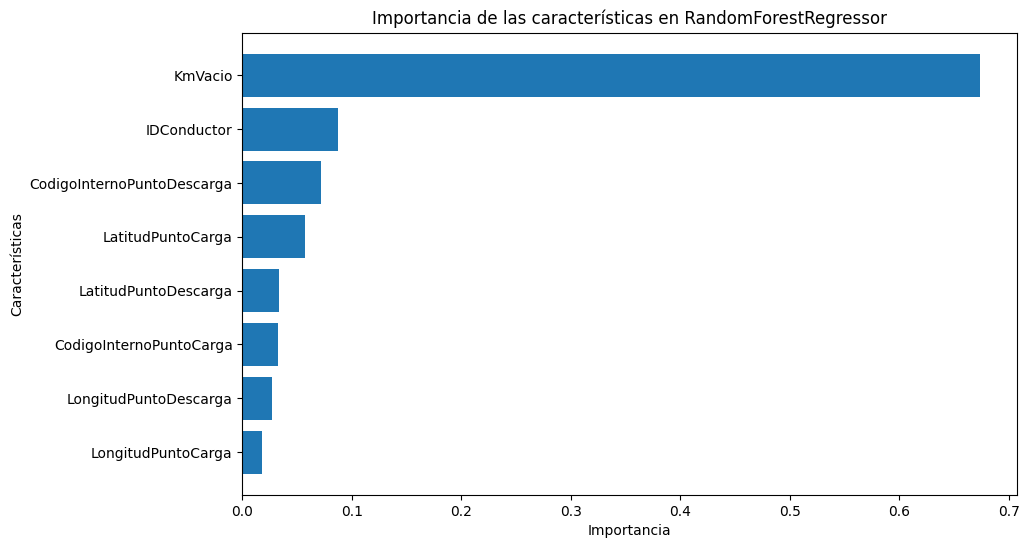

In [7]:
importancias = model.feature_importances_

# Crear un DataFrame para visualizar mejor la importancia
importancia_features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importancias
})

# Ordenar el DataFrame por la importancia de las características en orden descendente
importancia_features = importancia_features.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las características
print(importancia_features)

# Visualizar la importancia de las características utilizando un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importancia_features['Feature'], importancia_features['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características en RandomForestRegressor')
plt.gca().invert_yaxis()  # Para que las características más importantes aparezcan en la parte superior
plt.show()

In [8]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 5.743157126557944
Mean Squared Error (MSE): 80.46179062546335
R-squared (R2): 0.890362501196906


In [9]:
import joblib
pathArchivoAGenerar = os.getcwd() + "/modelos/" + nombreModeloSalida
pathArchivoAGenerar

if(os.path.exists(pathArchivoAGenerar)):
    print("El archvivo " + pathArchivoAGenerar +" ya existe")
    # print("Quiere sobreescribir el archivo (s/n)")
    respuesta = input("Quiere sobreescribir el archivo (s/n)")
    # print(respuesta)
    if (respuesta == 's'):
        print("Sobreescribiendo el archivo" + pathArchivoAGenerar)
        joblib.dump(model, pathArchivoAGenerar) 
        joblib.dump(label_encoder_array, os.getcwd()+ "/modelos/" + "encoderArray.joblib")
        np.savetxt(os.getcwd() + "/modelos/" + "conductores.csv", data['IDConductor'].unique(), delimiter=',', fmt='%s')
        paradasCarga = data[['CodigoInternoPuntoCarga', 'LatitudPuntoCarga', 'LongitudPuntoCarga']].drop_duplicates()
        paradasDescarga = data[['CodigoInternoPuntoDescarga', 'LatitudPuntoDescarga', 'LongitudPuntoDescarga']].drop_duplicates()
        paradasCarga.to_csv(os.getcwd() + "/modelos/" + "paradasCarga.csv", index=False)
        paradasDescarga.to_csv(os.getcwd() + "/modelos/" + "paradasDescarga.csv", index=False)
else:
    print("Generando el archivo " + pathArchivoAGenerar)
    joblib.dump(model, pathArchivoAGenerar) 
    joblib.dump(label_encoder_array, os.getcwd()+ "/modelos/" + "encoderArray.joblib")
    np.savetxt(os.getcwd() + "/modelos/" + "conductores.csv", data['IDConductor'].unique(), delimiter=',', fmt='%s')
    paradasCarga = data[['CodigoInternoPuntoCarga', 'LatitudPuntoCarga', 'LongitudPuntoCarga']].drop_duplicates()
    paradasDescarga = data[['CodigoInternoPuntoDescarga', 'LatitudPuntoDescarga', 'LongitudPuntoDescarga']].drop_duplicates()
    paradasCarga.to_csv(os.getcwd() + "/modelos/" + "paradasCarga.csv", index=False)
    paradasDescarga.to_csv(os.getcwd() + "/modelos/" + "paradasDescarga.csv", index=False)
    print("El archivo " + pathArchivoAGenerar + " ha sido generado")

El archvivo c:\Users\pablo.gallardo\Desktop\continuacion/modelos/forestRegressor.joblib ya existe


In [10]:
conductores = data['IDConductor'].unique()
paradasCarga = pd.read_csv(r"./modelos/paradasCarga.csv")
paradasDescarga = pd.read_csv(r"./modelos/paradasDescarga.csv")
conductores.shape
import random

paradaCargaIndex = random.randint(0, len(paradasCarga)-1)
print(paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga, paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga, paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga)
paradaDescargaIndex = random.randint(0, len(paradasDescarga)-1)
lista_conductores_puntuacion = []
for conductor in conductores:
    km_vacio = random.randint(50, 400)
    to_pred = pd.DataFrame([{
        'IDConductor': conductor, 
        'CodigoInternoPuntoCarga': paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga,  
        'LatitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga,
        'LongitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga,
        'CodigoInternoPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].CodigoInternoPuntoDescarga,
        'LatitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LatitudPuntoDescarga,
        'LongitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LongitudPuntoDescarga,
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
            i+=1
    # print(to_pred)
    # print(to_pred['IDconductor'], "\n", to_pred['CodigoInternoParadaCarga'], "\n", to_pred['CodigoInternoParadaDescarga'])

    prediction = model.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction}
    lista_conductores_puntuacion.append(puntuacion_conductor)


print(lista_conductores_puntuacion)

conductores_ordenados = sorted(lista_conductores_puntuacion, key=lambda x: x["Prediccion"], reverse=True)
conductores_menosKM = sorted(lista_conductores_puntuacion, key=lambda x: x['KmVacio'], reverse=False)

for conductor in conductores_menosKM[:5]:
    print(conductor)

print("Mejores conductores:")
for conductor in conductores_ordenados[:5]:
    print(conductor)
    

100534173 41.8381 12.6549
[{'Conductor': 'Y4446672G', 'KmVacio': 251, 'Prediccion': array([27.66568087])}, {'Conductor': '46401708J', 'KmVacio': 324, 'Prediccion': array([12.88586197])}, {'Conductor': '52069433D', 'KmVacio': 62, 'Prediccion': array([67.9346179])}, {'Conductor': 'X6557371W', 'KmVacio': 142, 'Prediccion': array([68.74300861])}, {'Conductor': 'Y7449758A', 'KmVacio': 279, 'Prediccion': array([16.8286539])}, {'Conductor': 'X5821319L', 'KmVacio': 230, 'Prediccion': array([36.07554919])}, {'Conductor': '39847805Y', 'KmVacio': 149, 'Prediccion': array([75.4479298])}, {'Conductor': 'X5480310P', 'KmVacio': 314, 'Prediccion': array([9.75546954])}, {'Conductor': '39856757B', 'KmVacio': 121, 'Prediccion': array([79.11899851])}, {'Conductor': '39940701M', 'KmVacio': 168, 'Prediccion': array([52.81793777])}, {'Conductor': 'X8875206N', 'KmVacio': 279, 'Prediccion': array([14.16200366])}, {'Conductor': '77832943T', 'KmVacio': 238, 'Prediccion': array([31.19729208])}, {'Conductor': '059

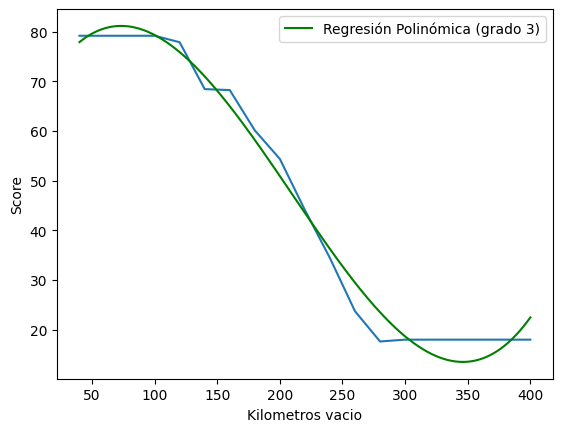

In [11]:
lista_conductorX_puntuaciones = []
conductor = "Y4446672G"
for km_vacio in range(40, 401, 20):
    to_pred = pd.DataFrame([{
        'IDConductor': conductor, 
        'CodigoInternoPuntoCarga': paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga,  
        'LatitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga,
        'LongitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga,
        'CodigoInternoPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].CodigoInternoPuntoDescarga,
        'LatitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LatitudPuntoDescarga,
        'LongitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LongitudPuntoDescarga,
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
            i+=1

    
    prediction = model.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction[0]}
    lista_conductorX_puntuaciones.append(puntuacion_conductor)
    

# for item in lista_conductorX_puntuaciones:
#     print(item)


# Extraer los valores de KmVacio y Prediccion
km_vacio = np.array([x["KmVacio"] for x in lista_conductorX_puntuaciones])
predicciones = np.array([x["Prediccion"] for x in lista_conductorX_puntuaciones])

# Ajustar una regresión polinómica (grado 2 en este caso)
grado = 3
coef = np.polyfit(km_vacio, predicciones, grado)
polinomio = np.poly1d(coef)

# Calcular los valores predichos usando el polinomio
y_pred2 = polinomio(km_vacio)

plt.plot(range(40, 401, 20), [x["Prediccion"] for x in lista_conductorX_puntuaciones])
# Graficar la curva de regresión polinómica
x_range = np.linspace(km_vacio.min(), km_vacio.max(), 500)
plt.plot(x_range, polinomio(x_range), color='green', label=f'Regresión Polinómica (grado {grado})')
plt.xlabel('Kilometros vacio')
plt.ylabel('Score')
plt.legend()
plt.show()